In [18]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam
from matplotlib import pyplot as plt
import glob

In [19]:
models.alexnet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [49]:
class SceneClassify(nn.Module):
    def __init__(self, num_class, pretrain = False):
        super(SceneClassify, self).__init__()
        self.alexnet = torchvision.models.alexnet(pretrained=pretrain)
        self.relu = nn.ReLU()
        if pretrain:
            # Freeze pre trained weights
            for param in self.alexnet.parameters():
                param.requires_grad = False
            
            self.alexnet.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(in_features=9216, out_features=num_class)
            )
    
    def forward(self, x):
        x = self.alexnet.features(x)
        x = x.view(x.size(0), -1) # flatten
        x = self.alexnet.classifier(x)

        return self.relu(x)


In [50]:
def data_processing():
    # Alexnet transformer
    transformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_loader = DataLoader(
        torchvision.datasets.ImageFolder(train_path, transform=transformer),
        batch_size = 256,
        shuffle = True
    )

    test_loader = DataLoader(
        torchvision.datasets.ImageFolder(test_path, transform=transformer),
        batch_size = 256,
        shuffle = True
    )

    return train_loader, test_loader


In [57]:
def train():
    total_train_loss = 0.0
    total_train_accuracy = 0.0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(images)
        loss = loss_function(pred, labels)

        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, prediction = torch.max(pred.data, 1)
        total_train_accuracy += int(torch.sum(prediction == labels.data))

    return total_train_loss, total_train_accuracy


In [58]:
def test():
    test_accuracy = 0.0
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1) # get catagory id
        test_accuracy += int(torch.sum(prediction == labels.data))

    return test_accuracy

In [62]:
total_epoch = 2
best_accuracy = 0.0
train_path = "./data/seg_train"
test_path = "./data/seg_test"
train_count = len(glob.glob(train_path + '/**/*.jpg'))
test_count = len(glob.glob(test_path + '/**/*.jpg'))

model = SceneClassify(num_class = 6, pretrain=True)
train_loader, test_loader = data_processing()
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

train_loss, train_accuracy, test_accuracy = [], [], []
for epoch in range(total_epoch):
    total_train_loss, total_train_accuracy = train()

    total_train_loss = total_train_loss / (epoch + 1)
    train_loss.append(total_train_loss)

    total_train_accuracy = total_train_accuracy / train_count
    train_accuracy.append(total_train_accuracy)

    model.eval()
    total_test_accuracy = test()
    total_test_accuracy = total_test_accuracy / test_count
    test_accuracy.append(total_test_accuracy)

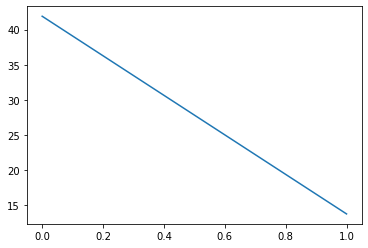

In [63]:
plt.plot(train_loss)

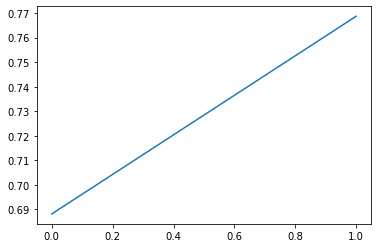

In [64]:
plt.plot(train_accuracy)

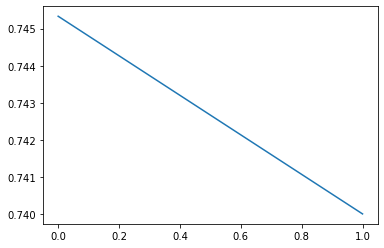

In [65]:
plt.plot(test_accuracy )